# Question 2


### About RANSAC
RANSAC stands for "Random Sample Consensus," and it is an iterative algorithm used for robust model fitting in the presence of outliers. RANSAC is commonly employed in computer vision, image processing, and other fields where data points may contain significant noise or outliers.

The main idea behind RANSAC is to estimate model parameters from a dataset that may contain outliers by repeatedly selecting a random subset of data points (a "minimal sample") to form a potential model. The algorithm then evaluates how well this model fits the entire dataset and counts the number of inliers (data points that fit the model) within a certain tolerance or error threshold. 

The key steps of the RANSAC algorithm are as follows:

1. **Initialization:** Choose a minimum sample size (the smallest number of data points needed to estimate the model), a maximum number of iterations, and a tolerance (error threshold).

2. **Iteration:** Repeat the following steps until the maximum number of iterations is reached:
   - Randomly select a minimal sample (e.g., 2 points for a line, 3 points for a circle).
   - Fit a model to the minimal sample (e.g., estimate a line or a circle).
   - Calculate the error or distance between the model and all data points.
   - Count the number of inliers (data points within the error threshold of the model).

3. **Model Evaluation:** After the iterations, select the model with the largest number of inliers as the best model.

4. **Refinement (Optional):** Refine the model using all inliers (data points that fit the best model). This step is optional and depends on the specific application.

RANSAC is particularly useful when dealing with datasets containing outliers or data points that do not conform to the assumed model. It can be applied to various model-fitting problems, such as line fitting, circle fitting, homography estimation, and more.

The algorithm's robustness comes from its ability to focus on the most consistent subset of data points while ignoring outliers. However, RANSAC does not guarantee finding the global optimal solution, and its success depends on appropriate parameter settings and the characteristics of the data.

## Part (a)

Estimate the line using the RNASAC algorithm (must be coded on your own). Ensure that you apply the constraint ∥[a,b]⊺∥ = 1. Carefuly select the error (the normal distance to the estimated line) and the number of points that must be in the consensus.

In [1]:
import numpy as np

# Function to calculate the line parameters [a, b, d] from two points
def calculate_line_parameters(point1, point2):
    x1, y1 = point1
    x2, y2 = point2
    a = y2 - y1
    b = x1 - x2
    d = x2 * y1 - x1 * y2
    norm = np.sqrt(a ** 2 + b ** 2)
    a /= norm
    b /= norm
    return a, b, d

# Function to calculate the distance of a point from a line
def point_to_line_distance(a, b, d, point):
    x, y = point
    return np.abs(a * x + b * y - d) / np.sqrt(a ** 2 + b ** 2)

# Function to fit a line using RANSAC
def fit_line_ransac(points, num_iterations, error_threshold, min_consensus):
    best_line = None
    best_inliers = []

    for _ in range(num_iterations):
        # Randomly sample two points from the data
        sample_indices = np.random.choice(len(points), 2, replace=False)
        sample_points = points[sample_indices]

        # Compute the line parameters [a, b, d]
        a, b, d = calculate_line_parameters(sample_points[0], sample_points[1])

        # Calculate the error (perpendicular distance) for all points
        errors = np.array([point_to_line_distance(a, b, d, point) for point in points])

        # Find inliers based on the error threshold
        inliers = np.where(errors < error_threshold)[0]

        # Check if we have a new best model with more inliers
        if len(inliers) >= min_consensus and len(inliers) > len(best_inliers):
            best_inliers = inliers
            best_line = (a, b, d)

    return best_line, best_inliers

## Part (b)

Subtract the consensus of the best line (remnant) and estimate the circle that fits the remnant using RANSAC. Carefully select the threshold of error (radial error) and the number of points that must be in the consensus.

In [2]:
import numpy as np

# Function to calculate the circle parameters [x, y, r] from three points
def calculate_circle_parameters(points):
    x1, y1 = points[0]
    x2, y2 = points[1]
    x3, y3 = points[2]
    
    D = 2 * (x1 * (y2 - y3) + x2 * (y3 - y1) + x3 * (y1 - y2))
    Ux = ((x1**2 + y1**2) * (y2 - y3) + (x2**2 + y2**2) * (y3 - y1) + (x3**2 + y3**2) * (y1 - y2)) / D
    Uy = ((x1**2 + y1**2) * (x3 - x2) + (x2**2 + y2**2) * (x1 - x3) + (x3**2 + y3**2) * (x2 - x1)) / D
    
    r = np.sqrt((x1 - Ux)**2 + (y1 - Uy)**2)
    
    return Ux, Uy, r

# Function to fit a circle using RANSAC
def fit_circle_ransac(points, num_iterations, error_threshold, min_consensus):
    best_circle = None
    best_inliers = []

    for _ in range(num_iterations):
        # Randomly sample three points from the data
        sample_indices = np.random.choice(len(points), 3, replace=False)
        sample_points = points[sample_indices]

        # Compute the circle parameters [x, y, r]
        x, y, r = calculate_circle_parameters(sample_points)

        # Calculate the radial error for all points
        radial_errors = np.abs(np.sqrt((points[:, 0] - x)**2 + (points[:, 1] - y)**2) - r)

        # Find inliers based on the radial error threshold
        inliers = np.where(radial_errors < error_threshold)[0]

        # Check if we have a new best model with more inliers
        if len(inliers) >= min_consensus and len(inliers) > len(best_inliers):
            best_inliers = inliers
            best_circle = (x, y, r)

    return best_circle, best_inliers


## Part (c)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle


# Generate a noisy point set conforming to a line and a circle
np.random.seed(0)
N = 100
half_n = N // 2

r = 10
x0_gt, y0_gt = 2, 3  # Center
s = r / 16
t = np.random.uniform(0, 2 * np.pi, half_n)
n = s * np.random.randn(half_n)
x, y = x0_gt + (r + n) * np.cos(t), y0_gt + (r + n) * np.sin(t)
X_circ = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

s = 1.
m, b = -1, 2

x = np.linspace(-12, 12, half_n)
y = m * x + b + s * np.random.randn(half_n)

X_line = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

X = np.vstack((X_circ, X_line))  # All points


In [4]:

# Estimate the line using RANSAC
num_iterations_line = 1000
error_threshold_line = 0.9  # Adjust based on the noise level in your data
min_consensus_line = 20     # Adjust based on the expected number of inliers

best_line, line_inliers = fit_line_ransac(X_line, num_iterations_line, error_threshold_line, min_consensus_line)

# Estimate the circle using RANSAC
num_iterations_circle = 1000
error_threshold_circle = 0.5  # Adjust based on the noise level in your data
min_consensus_circle = 20     # Adjust based on the expected number of inliers

best_circle, circle_inliers = fit_circle_ransac(X_circ, num_iterations_circle, error_threshold_circle, min_consensus_circle)


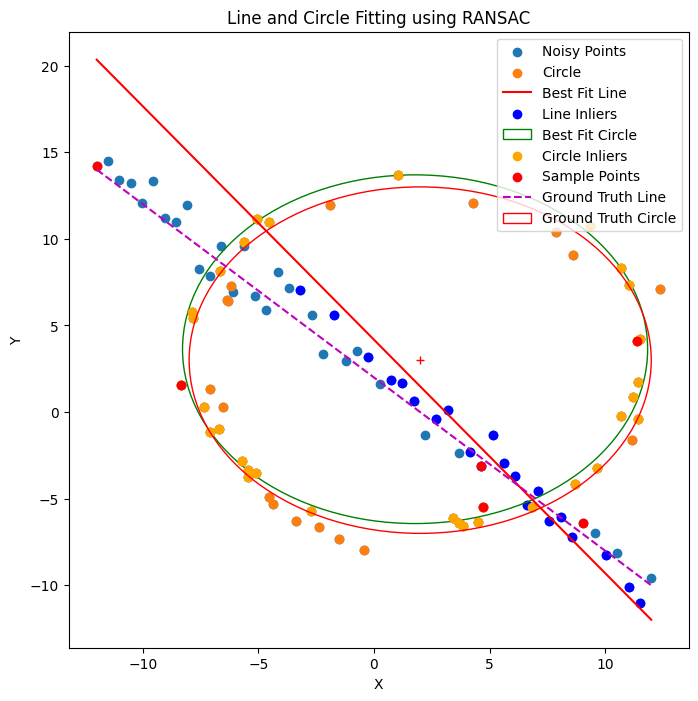

In [5]:

# Plotting the results
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

# Scatter plot for the noisy point set
ax.scatter(X[:, 0], X[:, 1], label='Noisy Points')
ax.scatter( X_circ[ : , 0 ] , X_circ [ : , 1 ] , label= 'Circle' )

# Plot the best-fit line and its inliers
if best_line is not None:  # Check if the line was successfully estimated
    x_min, x_max = np.min(X_line[:, 0]), np.max(X_line[:, 0])
    y_min, y_max = best_line[2] / best_line[1] - best_line[0] * x_min / best_line[1], \
                   best_line[2] / best_line[1] - best_line[0] * x_max / best_line[1]
    ax.plot([x_min, x_max], [y_min, y_max], color='red', label='Best Fit Line')
    ax.scatter(X_line[line_inliers, 0], X_line[line_inliers, 1], color='blue', label='Line Inliers')

# Plot the best-fit circle and its inliers
if best_circle is not None:  # Check if the circle was successfully estimated
    x_circle, y_circle, r_circle = best_circle
    circle = Circle((x_circle, y_circle), r_circle, color='green', fill=False, label='Best Fit Circle')
    ax.add_patch(circle)
    ax.scatter(X_circ[circle_inliers, 0], X_circ[circle_inliers, 1], color='orange', label='Circle Inliers')

# Plot the sample of three points used for line and circle estimation
if best_line is not None and best_circle is not None:
    sample_points = np.vstack((X_line[np.random.choice(len(X_line), 3, replace=False)],
                               X_circ[np.random.choice(len(X_circ), 3, replace=False)]))
    ax.scatter(sample_points[:, 0], sample_points[:, 1], color='red', label='Sample Points')

# Add the ground truth line
ax.plot(x, m * x + b, color='m', linestyle='--', label='Ground Truth Line')

# Add the ground truth circle
circle_gt = Circle((x0_gt, y0_gt), r, color='red', fill=False, label='Ground Truth Circle')
ax.add_patch(circle_gt)
ax.plot(x0_gt, y0_gt, '+', color='red')

# Add legend and labels
ax.legend()
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Line and Circle Fitting using RANSAC')

plt.show()


## Part(d)

If you fit the circle first before fitting the line in a RANSAC-based approach, the behavior and results might change depending on the specific characteristics of your data and the parameters you use. Here are some potential outcomes:

1. **Circle Estimation Success:** If the circle estimation successfully finds the circle parameters that fit the circle data points well, it will result in a good estimate of the circle's center (`x`, `y`) and radius (`r`).

2. **Line Estimation Impact:** After fitting the circle, you can then proceed to fit the line to the remaining points (those not included in the circle inliers). Since the circle inliers have been removed from the dataset, the line estimation process will focus on the remaining points that are more likely to belong to the line. This can potentially result in a more accurate line estimation compared to fitting the line first.

3. **Dependence on Data Characteristics:** The success of fitting the circle first depends on the specific characteristics of your data. If the data conforms more closely to a circle, fitting the circle first can lead to a better initial estimate of the circular portion, potentially making it easier to identify and remove circle inliers when fitting the line. However, if the data has a stronger linear component, fitting the line first might provide a more accurate initial estimate.

4. **Parameter Sensitivity:** The success of this approach is also sensitive to the choice of parameters such as the number of RANSAC iterations, error thresholds, and the minimum number of inliers required for consensus. You may need to adjust these parameters based on your data and the desired results.

In summary, fitting the circle first can be a valid approach, especially if you believe that the circular component of the data is more prominent or if you have prior knowledge about the data's characteristics. However, the choice of whether to fit the circle or the line first should be based on the specific characteristics of your dataset and your problem requirements. You may want to experiment with both approaches and choose the one that gives you the best results for your particular use case.

## Provided Code

In [ ]:
# Generation of a Noisy Point Set Conforming to a Line and a Circle
import numpy as np
from scipy.optimize import minimize
from scipy import linalg
import matplotlib.pyplot as plt
import tikzplotlib

# np . random. seed ( 0 )
N = 100
half_n = N//2

r = 10
x0_gt , y0_gt = 2 , 3 # Center
s = r /16
t = np.random. uniform(0 , 2*np . pi , half_n )
n = s*np . random. randn ( half_n )
x , y = x0_gt + ( r + n)*np . cos ( t ) , y0_gt + ( r + n)*np . sin ( t )
X_circ = np . hstack ( ( x.reshape ( half_n , 1 ) , y.reshape ( half_n , 1 ) ) )
s = 1.
m, b = -1, 2

x = np .linspace(-12, 12 , half_n )
y = m*x + b + s*np . random. randn ( half_n )

X_line = np . hstack ( ( x . reshape ( half_n , 1 ) , y . reshape ( half_n , 1 ) ) )

X = np . vstack ( ( X_circ , X_line ) ) # All points

fig , ax = plt . subplots (1 ,1 , figsize =(8 ,8) )

ax.scatter( X_line [ : , 0 ] , X_line [ : , 1 ] , label= 'Line')
ax.scatter( X_circ [ : , 0 ] , X_circ [ : , 1 ] , label= 'Circle' )

circle_gt = plt.Circle ( ( x0_gt , y0_gt ) , r , color= 'g' , fill =False , label= 'Ground truth circle' )
ax.add_patch ( circle_gt )
ax.plot( ( x0_gt ) , ( y0_gt ) , '+' , color= 'g' )

x_min , x_max = ax.get_xlim ( )
x_ = np.array ( [ x_min , x_max ] )

y_ = m*x_ + b

plt . plot ( x_ , y_ , color= 'm' , label= 'Ground truth line' )
plt . legend ( )